# 단순 절대 모멘텀
- 투자 기간 : 1986년 1월~2017년 6월
- 투자 대상 : 코스피지수
- 매수 규칙 : 당월 추가 > n 개월 전 주가(n개월 모멘텀 > 0) → 주식 매수
- 매도 규칙 : 당월 주가 < n 개월 전 주가(개월 모멘텀 < 0) → 주식 매도, 현금 보유
- 문제점
  1. 1~12개월 모멘텀이 모두 잘 작동하는데 대체 어느 모멘텀을 기준으로 투자해야 하는지 모릅니다.
  2. 변동성이 크게 줄긴 했어도 사람에 따라 이 정도의 손실도 크다고 생각할 수도 있고, 시장 상황에 따라 우월하게 나타나는 모멘텀 기간 값이 그때마다 다릅니다.
  3. 모멘텀 전략이 급락장에서의 손실을 크게 줄일 수 있다는 장점이 있지만, 추세추종 매매의 본질상 오히려 횡보 구간에서는 손실이 커집니다.
- 해결법
  - 1, 2번 문제는 평균 모멘텀 스코어 도입
  - 3번(횡보 구간) 문제
      1. 주식과 상관성이 낮은 자산을 분산해서 혼합 : 현금과 채권(동일한 자산군으로 취급하여 모멘텀 비중도 동일하게 계산하여 투자 비중 결정)
      2. 전략 수익곡선에 평균 모멘텀 스코어 전략 적용('**수익곡선 모멘텀 전략**')

In [1]:
from settings import *

In [2]:
kospi = fdr.DataReader("KS11")[['Close']] # dataframe [['Close]]
kospi.columns = ['KOSPI']
kospi.info() # 1981-05-01 to 2022-01-19

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10878 entries, 1981-05-01 to 2022-01-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   KOSPI   10878 non-null  float64
dtypes: float64(1)
memory usage: 170.0 KB


In [3]:
data = kospi['1986-1':'2017-6'].copy()
data_m = data.resample('MS').first() # 월초
data_m.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 378 entries, 1986-01-01 to 2017-06-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   KOSPI   378 non-null    float64
dtypes: float64(1)
memory usage: 5.9 KB


In [4]:
data_m

,KOSPI
Date,
1986-01-01,161.400
1986-02-01,162.450
1986-03-01,179.330
1986-04-01,200.150
1986-05-01,202.880
...,...
2017-02-01,2080.480
2017-03-01,2102.650
2017-04-01,2167.510


In [5]:
start = '1986-1'
end = '2017-6'

In [6]:
def momentum(data, trend, name='1개월모멘텀'):
    s = bt.Strategy(
        name,
        [
            bt.algos.RunMonthly(run_on_end_of_period=False), # 월초
            bt.algos.SelectWhere(trend), # !!!
            bt.algos.WeighEqually(),
            bt.algos.PrintInfo("{now} {temp}"),
            bt.algos.Rebalance()
        ])
    test = bt.Backtest(s, data, initial_capital=100000000)

    return test

In [7]:
bt_kospi = long_only_ew(data_m, ["KOSPI"], "KOSPI", initial_capital=100000000)

## 비중 데이터프레임을 별도로 만들어서 일반화 함 (SelectWhere(weights))

In [8]:
# 절대 모멘텀은 이동평균이 아니라 단순히 과거 시점 대비 현재를 비교한다.
# 1개월 모멘텀 (data는 월간 데이터)
prev = data_m.shift(1)
trend = prev.copy()
trend[data_m > prev] = True
trend[data_m <= prev] = False
trend[prev.isnull()] = False
trend.tail()

,KOSPI
Date,
2017-02-01,True
2017-03-01,True
2017-04-01,True
2017-05-01,True
2017-06-01,True


In [9]:
bt_1m = momentum(data_m, trend, "1개월모멘텀")
rm1 = bt.run(bt_1m)

1986-01-01 00:00:00 {'selected': [], 'weights': {}}
1986-02-01 00:00:00 {'selected': ['KOSPI'], 'weights': {'KOSPI': 1.0}}
1986-03-01 00:00:00 {'selected': ['KOSPI'], 'weights': {'KOSPI': 1.0}}
1986-04-01 00:00:00 {'selected': ['KOSPI'], 'weights': {'KOSPI': 1.0}}
1986-05-01 00:00:00 {'selected': ['KOSPI'], 'weights': {'KOSPI': 1.0}}
1986-06-01 00:00:00 {'selected': ['KOSPI'], 'weights': {'KOSPI': 1.0}}
1986-07-01 00:00:00 {'selected': ['KOSPI'], 'weights': {'KOSPI': 1.0}}
1986-08-01 00:00:00 {'selected': ['KOSPI'], 'weights': {'KOSPI': 1.0}}
1986-09-01 00:00:00 {'selected': [], 'weights': {}}
1986-10-01 00:00:00 {'selected': [], 'weights': {}}
1986-11-01 00:00:00 {'selected': [], 'weights': {}}
1986-12-01 00:00:00 {'selected': ['KOSPI'], 'weights': {'KOSPI': 1.0}}
1987-01-01 00:00:00 {'selected': [], 'weights': {}}
1987-02-01 00:00:00 {'selected': ['KOSPI'], 'weights': {'KOSPI': 1.0}}
1987-03-01 00:00:00 {'selected': ['KOSPI'], 'weights': {'KOSPI': 1.0}}
1987-04-01 00:00:00 {'selected

In [10]:
rm_kospi = bt.run(bt_kospi)
rm1_assets = bt.run(bt_kospi, bt_1m)

1986-01-01 00:00:00


In [11]:
rm1_assets.set_date_range('1986-02-01')
rm1_assets.display()

Stat                 KOSPI       1개월모멘텀
-------------------  ----------  -------------
Start                1986-02-01  1986-02-01
End                  2017-06-01  2017-06-01
Risk-free rate       0.00%       0.00%

Total Return         1343.28%    1570.26%
Daily Sharpe         -           -
Daily Sortino        -           -
CAGR                 8.89%       9.40%
Max Drawdown         -72.43%     -30.90%
Calmar Ratio         0.12        0.30

MTD                  5.63%       5.63%
3m                   11.51%      11.51%
6m                   18.19%      15.72%
YTD                  18.19%      15.72%
1Y                   18.25%      17.16%
3Y (ann.)            5.41%       9.06%
5Y (ann.)            5.03%       5.53%
10Y (ann.)           3.17%       3.17%
Since Incep. (ann.)  8.89%       9.40%

Daily Sharpe         -           -
Daily Sortino        -           -
Daily Mean (ann.)    -           -
Daily Vol (ann.)     -           -
Daily Skew           -           -
Daily Kurt           - 

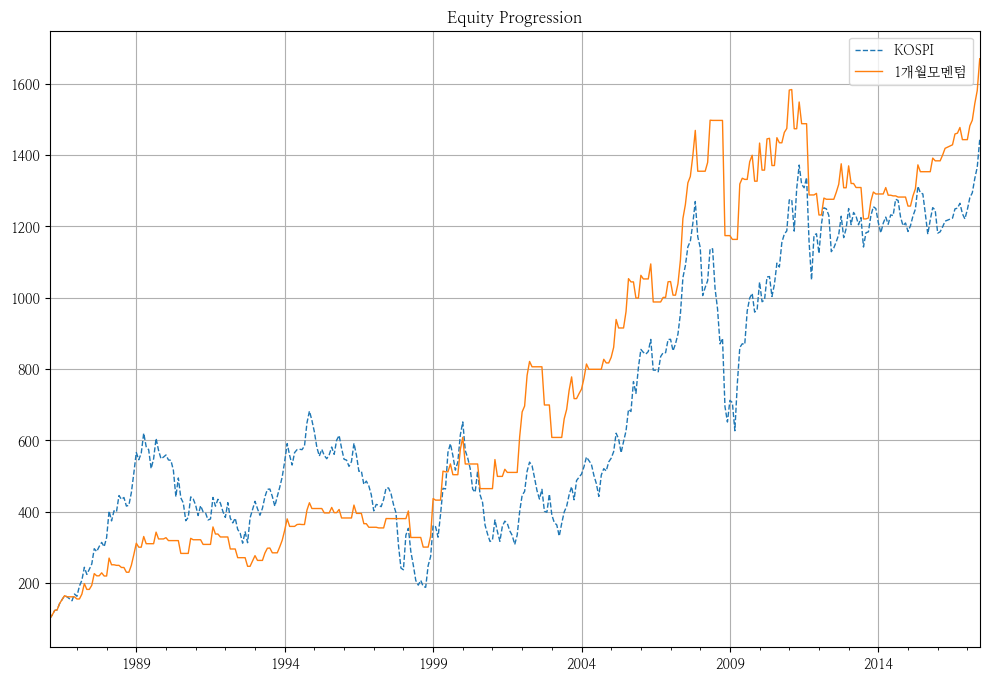

In [12]:
rm_kospi.set_date_range('1986-02-01')
rm1.set_date_range('1986-02-01')
ax1 = rm_kospi.plot(ls='--', figsize=(12, 8));
rm1.plot(ax=ax1, figsize=(12,8));

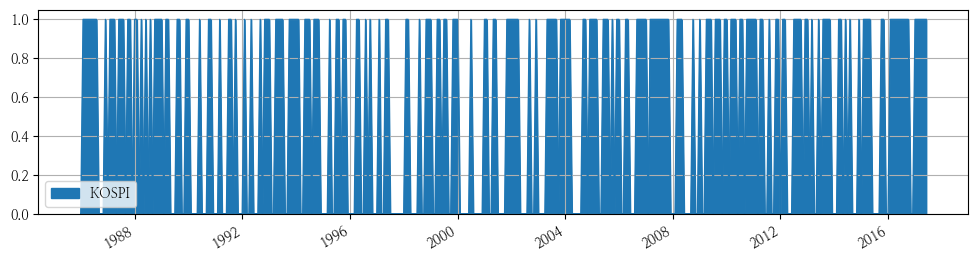

In [13]:
rm1.get_security_weights().plot.area(figsize=(12,3));

In [14]:
rm1.get_transactions().head(10)

,,price,quantity
Date,Security,,
1986-02-01,KOSPI,162.450,615574.000
1986-09-01,KOSPI,262.340,-615574.000
1986-12-01,KOSPI,275.150,586915.000
1987-01-01,KOSPI,264.820,-586915.000
1987-02-01,KOSPI,310.830,500038.000
1987-05-01,KOSPI,364.550,-500038.000
1987-06-01,KOSPI,387.440,470495.000
1987-09-01,KOSPI,468.380,-470495.000
1987-10-01,KOSPI,491.600,448272.000


In [15]:
# 거래 발생
rm1.backtest_list[0].positions.diff(1).head(10)

,KOSPI
1985-12-31,NaN
1986-01-01,0.000
1986-02-01,615574.000
1986-03-01,0.000
1986-04-01,0.000
1986-05-01,0.000
1986-06-01,0.000
1986-07-01,0.000
1986-08-01,0.000
1986-09-01,-615574.000


In [16]:
# outlays 유가 증권 매입(매각)에 의해 총 지출된 금액(거래한 날만 나옴, 거래 없는 날 0)
# 19862-1 162.45*615574.0
rm1.backtest_list[0].strategy.outlays.head(10)

,KOSPI
1985-12-31,0.000
1986-01-01,0.000
1986-02-01,99999996.300
1986-03-01,0.000
1986-04-01,0.000
1986-05-01,0.000
1986-06-01,0.000
1986-07-01,0.000
1986-08-01,0.000
1986-09-01,-161489683.160


## 1-12개월별 절대 모멘텀 백테스팅

In [19]:
# Print Off
def momentum(data, trend, name='1개월모멘텀'):
    s = bt.Strategy(
        name,
        [
            bt.algos.RunMonthly(run_on_end_of_period=False),
            bt.algos.SelectWhere(trend), # !!!
            bt.algos.WeighEqually(),
#             bt.algos.PrintInfo("{now} {temp}"),
            bt.algos.Rebalance()
        ])
    test = bt.Backtest(s, data, initial_capital=100000000)

    return test

In [20]:
#%% 1~12개월에 대한 백테스팅
# https://blog.naver.com/hermian71/222577014997
test_m_mom = dict()
for i in range(1, 13):
    prev = data_m.shift(i)
    trend = prev.copy()
    trend[data_m > prev] = True
    trend[data_m <= prev] = False
    trend[prev.isnull()] = False
    test_m_mom[i] = momentum(data_m, trend, name=str(i)+"개월모멘텀")

In [21]:
rm_1_12 = bt.run(*test_m_mom.values())

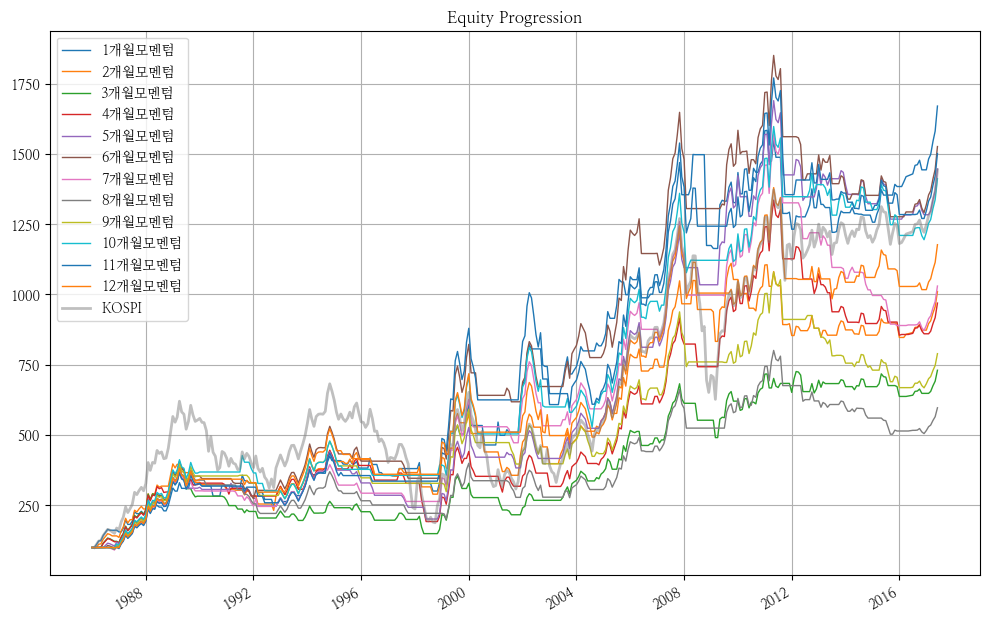

In [22]:
ax1 = rm_1_12.plot(figsize=(12, 8));
rm_kospi.plot(ax=ax1, lw=2, ls='-', color='gray', alpha=0.5, figsize=(12, 8));

plot_df()함수 사용(utils)

- legend 칼라와 순서를 맞춘다.

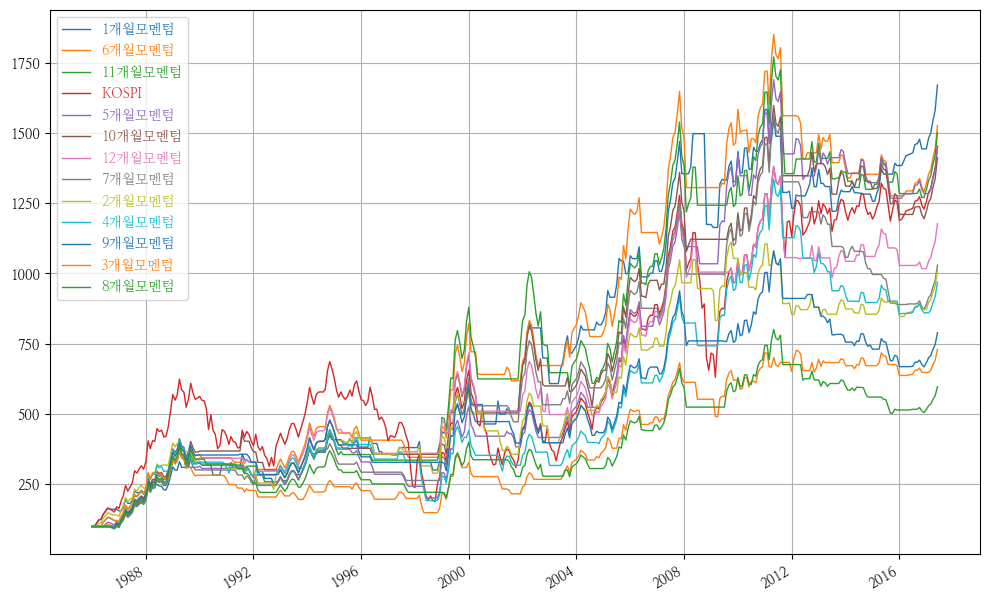

In [23]:
df = bt.merge(rm_1_12.prices, rm_kospi.prices)
plot_df(df, logy=False)

In [24]:
# legend의 순서가 그래프의 마지막값 순서
rm_1_12.prices.tail(1).T.sort_values(by='2017-06-1', ascending=False)

,2017-06-01
1개월모멘텀,1670.259
6개월모멘텀,1526.231
11개월모멘텀,1501.393
5개월모멘텀,1446.676
10개월모멘텀,1412.269
12개월모멘텀,1177.185
7개월모멘텀,1030.140
2개월모멘텀,1010.507
4개월모멘텀,969.458
9개월모멘텀,789.542


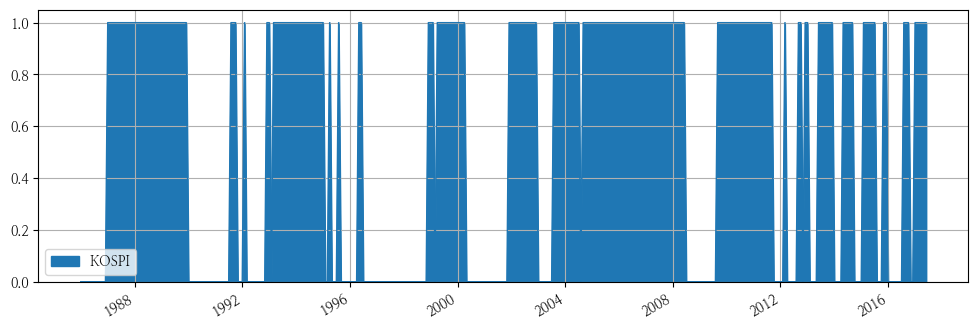

In [25]:
rm_1_12.get_security_weights(11).plot.area(figsize=(12,4));

In [26]:
rm369 = bt.run(test_m_mom[1], test_m_mom[3], test_m_mom[6],
               test_m_mom[9], test_m_mom[12], bt_kospi)

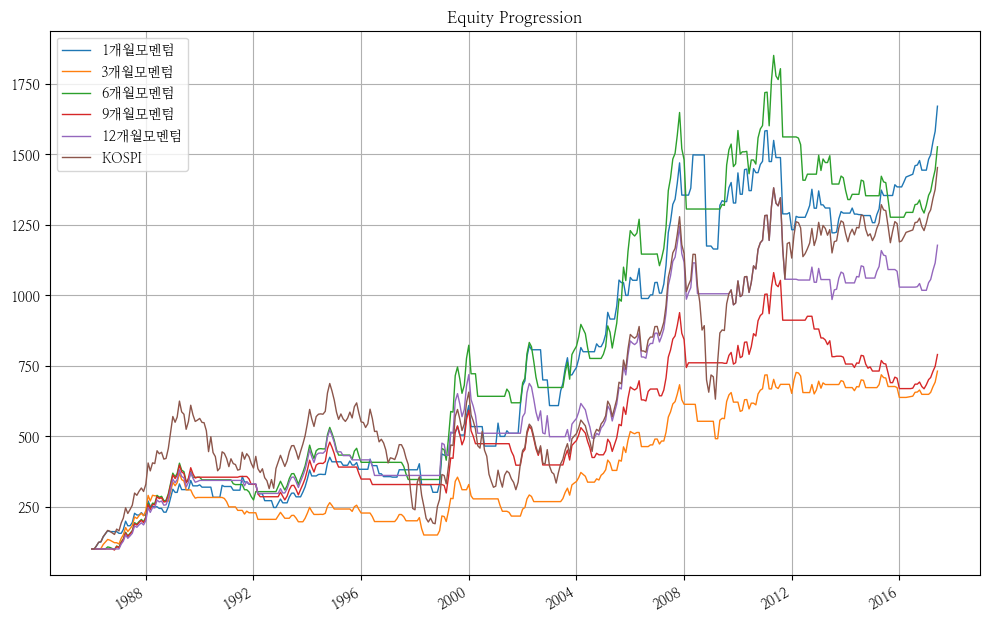

In [27]:
rm369.plot(figsize=(12,8));

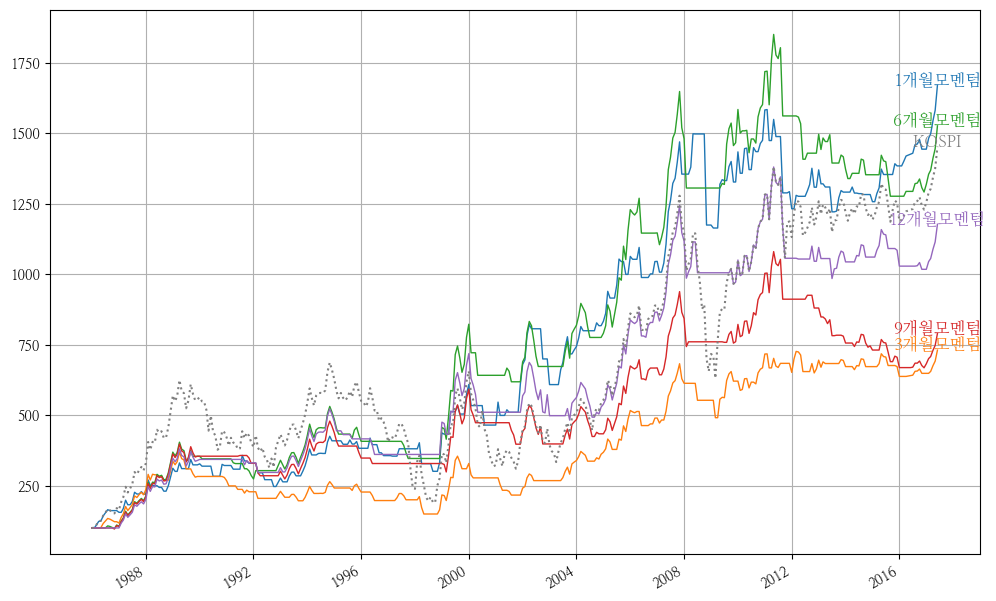

In [28]:
r = rm369.prices.rebase()
ax = r.iloc[:, 0:-1].plot(legend=False);# kospi제외
r.iloc[:,-1].plot(ax=ax, color='gray', lw=1.5, ls=':', label='KOSPI', figsize=(12,8));
# leg = ax.legend()
# print(dir(list(ax.get_lines())[0]))

# for l in list(ax.get_lines()):
#     print(l.get_label(), l.get_color())

for i, line in enumerate(list(ax.get_lines())):
    ax.text(r.index[-1], r.iloc[-1,i], line.get_label(), size=12, color=line.get_color(), ha='center');

# style = dict(size=12, color='black', ha='center')
# ax.text(r.index[-1], r.iloc[-1,0], '1개월모멘텀 ', **style)
# ax.text(r.index[-1], r.iloc[-1,1], '3개월모멘텀 ', **style)
# ax.text(r.index[-1], r.iloc[-1,2], '6개월모멘텀 ', **style)
# ax.text(r.index[-1], r.iloc[-1,3], '9개월모멘텀 ', **style)
# ax.text(r.index[-1], r.iloc[-1,4], '12개월모멘텀 ', **style)
# ax.text(r.index[-1], r.iloc[-1,5], 'KOSPI ', **style)
plt.show();

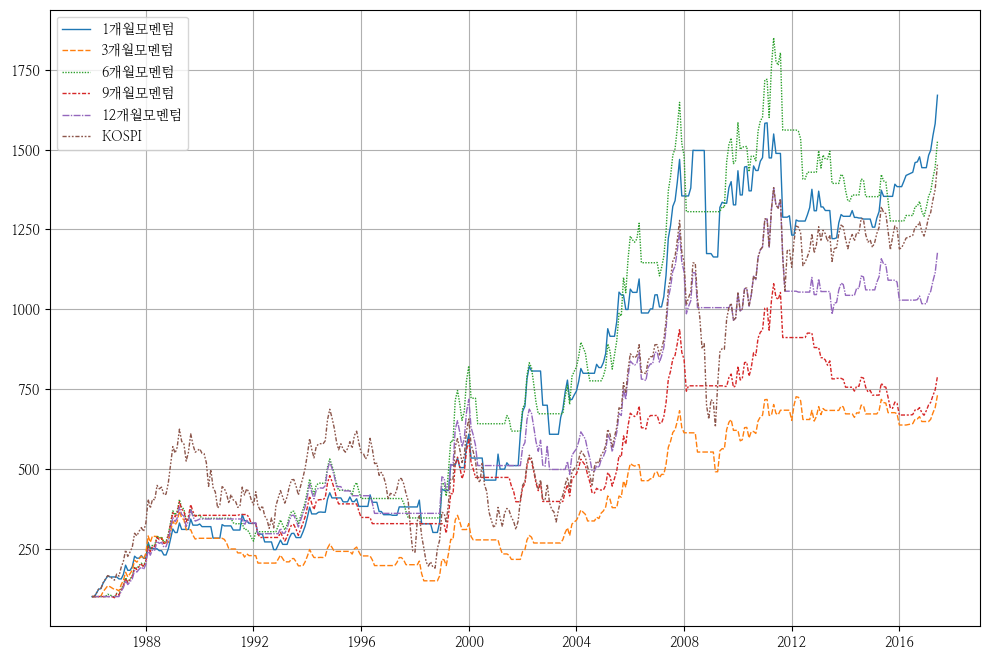

In [29]:
# %% seaborn으로 그리면
import seaborn as sns
plt.figure(figsize=(12,8))
sns.lineplot(data=r);

## bt의 Algo 클래스를 작성하여 동일 전략을 백테스팅 해보자.

In [30]:
class Signal(bt.Algo):
    """

    Mostly copied from StatTotalReturn

    Sets temp['Signal'] with total returns over a given period.

    Sets the 'Signal' based on the total return of each
    over a given lookback period.

    Args:
        * lookback (DateOffset): lookback period.
        * lag (DateOffset): Lag interval. Total return is calculated in
            the inteval [now - lookback - lag, now - lag]

    Sets:
        * stat

    Requires:
        * selected

    """


    def __init__(self, lookback=pd.DateOffset(months=3), lag=pd.DateOffset(days=0)):
        super(Signal, self).__init__()
        self.lookback = lookback
        self.lag = lag

    def __call__(self, target):
#         print(f"\n====== {target.now}, {self.lookback}")
        selected = target.temp['selected']
        t0 = target.now - self.lag

        if target.universe[selected].index[0] > (t0 - self.lookback): # !!!
            return False

        prc = target.universe[selected].loc[t0 - self.lookback:t0]
        # print(target.now, t0 , t0 - self.lookback, '\n', prc)

        trend = prc.iloc[-1]/prc.iloc[0] - 1
        signal = trend > 0.

        target.temp['Signal'] = signal.astype(float)

        return True



class WeighFromSignal(bt.Algo):

    """
    Sets temp['weights'] from the signal.
    Sets:
        * weights

    Requires:
        * selected

    """

    def __init__(self):
        super(WeighFromSignal, self).__init__()

    def __call__(self, target):
        selected = target.temp['selected']
        if target.temp['Signal'] is None:
            raise(Exception('No Signal!'))

        target.temp['weights'] = target.temp['Signal']
        return True

In [31]:
def abs_momentum_month(data, tickers = ['KOSPI'], n=1, lag=0, name="1개월모멘텀"):
    if n == 12: # months=12로 하면 이상하게 months=12, years=1이되어 24개월의 모멘텀을 구한다.
        offset = pd.DateOffset(years=1)
    else:
        offset = pd.DateOffset(months=n)

    s = bt.Strategy(
        name,
        [
            bt.algos.RunMonthly(run_on_end_of_period=False),
            bt.algos.SelectThese(tickers),
            Signal(lookback=offset, lag=pd.DateOffset(days=lag)),
            WeighFromSignal(),
            bt.algos.PrintInfo("{now} {temp}"),
            bt.algos.Rebalance()
        ]
    )

    t = bt.Backtest(s, data)
    return t

In [32]:
data = kospi[start:end].copy() # 일간 데이터
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8380 entries, 1986-01-04 to 2017-06-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   KOSPI   8380 non-null   float64
dtypes: float64(1)
memory usage: 130.9 KB


In [33]:
data

,KOSPI
Date,
1986-01-04,161.400
1986-01-06,158.970
1986-01-07,157.780
1986-01-08,159.450
1986-01-09,159.430
...,...
2017-06-26,2388.660
2017-06-27,2391.950
2017-06-28,2382.560


In [34]:
bt_c_1 = abs_momentum_month(data, ['KOSPI'], 1, lag=0, name='1개월')
r_c_1 = bt.run(bt_c_1)

1986-03-03 00:00:00 {'selected': ['KOSPI'], 'Signal': KOSPI   1.000
dtype: float64, 'weights': KOSPI   1.000
dtype: float64}
1986-04-01 00:00:00 {'selected': ['KOSPI'], 'Signal': KOSPI   1.000
dtype: float64, 'weights': KOSPI   1.000
dtype: float64}
1986-05-01 00:00:00 {'selected': ['KOSPI'], 'Signal': KOSPI   1.000
dtype: float64, 'weights': KOSPI   1.000
dtype: float64}
1986-06-02 00:00:00 {'selected': ['KOSPI'], 'Signal': KOSPI   1.000
dtype: float64, 'weights': KOSPI   1.000
dtype: float64}
1986-07-01 00:00:00 {'selected': ['KOSPI'], 'Signal': KOSPI   1.000
dtype: float64, 'weights': KOSPI   1.000
dtype: float64}
1986-08-01 00:00:00 {'selected': ['KOSPI'], 'Signal': KOSPI   1.000
dtype: float64, 'weights': KOSPI   1.000
dtype: float64}
1986-09-01 00:00:00 {'selected': ['KOSPI'], 'Signal': KOSPI   0.000
dtype: float64, 'weights': KOSPI   0.000
dtype: float64}
1986-10-02 00:00:00 {'selected': ['KOSPI'], 'Signal': KOSPI   0.000
dtype: float64, 'weights': KOSPI   0.000
dtype: float64}


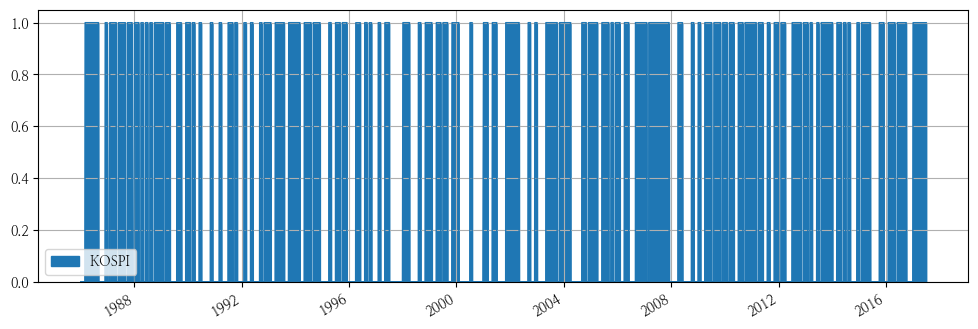

In [36]:
r_c_1.get_security_weights().plot.area(figsize=(12, 4));

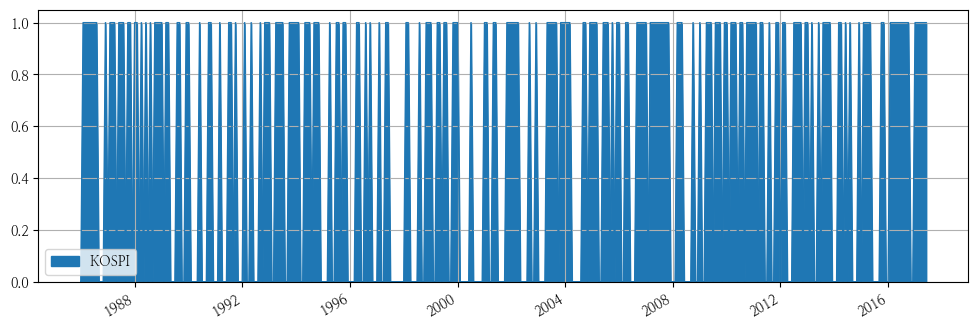

In [38]:
rm1.get_security_weights().plot.area(figsize=(12,4));

In [39]:
r_c_1.set_date_range('1986-3')
r_c_1.display()

Stat                 1개월
-------------------  ----------
Start                1986-03-03
End                  2017-06-30
Risk-free rate       0.00%

Total Return         1741.39%
Daily Sharpe         0.62
Daily Sortino        0.96
CAGR                 9.75%
Max Drawdown         -42.14%
Calmar Ratio         0.23

MTD                  1.89%
3m                   10.49%
6m                   18.04%
YTD                  18.04%
1Y                   23.11%
3Y (ann.)            10.55%
5Y (ann.)            5.73%
10Y (ann.)           3.31%
Since Incep. (ann.)  9.75%

Daily Sharpe         0.62
Daily Sortino        0.96
Daily Mean (ann.)    10.16%
Daily Vol (ann.)     16.39%
Daily Skew           0.07
Daily Kurt           13.13
Best Day             11.94%
Worst Day            -10.57%

Monthly Sharpe       0.55
Monthly Sortino      1.14
Monthly Mean (ann.)  10.83%
Monthly Vol (ann.)   19.68%
Monthly Skew         1.86
Monthly Kurt         14.11
Best Month           47.18%
Worst Month          -22.69%


In [40]:
r_c_1.prices.resample('M').last().to_drawdown_series().min()
r_c_1.prices.resample('MS').first().to_drawdown_series().min()

1개월   -0.400
dtype: float64

1개월   -0.406
dtype: float64

In [41]:
r_diff = bt.run(bt_1m)
r_diff.set_date_range('1986-3')
r_diff.display()

Stat                 1개월모멘텀
-------------------  -------------
Start                1986-03-01
End                  2017-06-01
Risk-free rate       0.00%

Total Return         1413.04%
Daily Sharpe         -
Daily Sortino        -
CAGR                 9.08%
Max Drawdown         -30.90%
Calmar Ratio         0.29

MTD                  5.63%
3m                   11.51%
6m                   15.72%
YTD                  15.72%
1Y                   17.16%
3Y (ann.)            9.06%
5Y (ann.)            5.53%
10Y (ann.)           3.17%
Since Incep. (ann.)  9.08%

Daily Sharpe         -
Daily Sortino        -
Daily Mean (ann.)    -
Daily Vol (ann.)     -
Daily Skew           -
Daily Kurt           -
Best Day             -
Worst Day            -

Monthly Sharpe       0.56
Monthly Sortino      1.07
Monthly Mean (ann.)  10.38%
Monthly Vol (ann.)   18.51%
Monthly Skew         0.89
Monthly Kurt         5.86
Best Month           31.75%
Worst Month          -21.57%

Yearly Sharpe        0.49
Yearly So

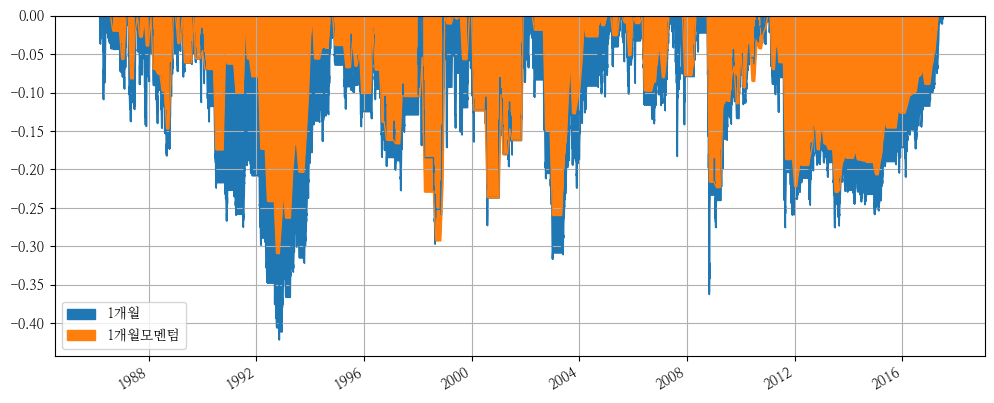

In [42]:
ax1 = r_c_1.prices.to_drawdown_series().plot.area(figsize=(12,5));
rm1.prices.to_drawdown_series().plot.area(ax=ax1, figsize=(12,5));

In [43]:
# PrintInfo 제거 버전
def abs_momentum_month(data, tickers = ['KOSPI'], n=1, lag=1, name="1개월모멘텀"):
    if n == 12: # months=12로 하면 이상하게 months=12, years=1이되어 24개월의 모멘텀을 구한다.
        offset = pd.DateOffset(years=1)
    else:
        offset = pd.DateOffset(months=n)

    s = bt.Strategy(
        name,
        [
            bt.algos.RunMonthly(run_on_end_of_period=False),
            bt.algos.SelectThese(tickers),
            Signal(lookback=offset, lag=pd.DateOffset(days=lag)),
            WeighFromSignal(),
#             bt.algos.PrintInfo("{now} {temp}"),
            bt.algos.Rebalance()
        ]
    )

    t = bt.Backtest(s, data)
    return t

In [44]:
test_mom = dict()
for i in range(1, 13):
    test_mom[i] = abs_momentum_month(data, ['KOSPI'], i, lag=1, name=str(i)+"개월모멘텀")

In [45]:
r1_12 = bt.run(*test_mom.values())

In [46]:
bt_kospi = long_only_ew(data, ["KOSPI"], "KOSPI", initial_capital=100000000)
r_kospi = bt.run(bt_kospi)

1986-01-04 00:00:00


In [47]:
r1_12.prices.tail(1).T.sort_values(by='2017-06-30', ascending=False)

,2017-06-30
11개월모멘텀,2054.432
12개월모멘텀,1519.194
3개월모멘텀,1489.280
6개월모멘텀,1461.036
10개월모멘텀,1317.913
5개월모멘텀,1168.645
7개월모멘텀,1097.956
1개월모멘텀,954.250
8개월모멘텀,792.747
2개월모멘텀,747.982


In [48]:
r1_12.stats

,1개월모멘텀,2개월모멘텀,3개월모멘텀,4개월모멘텀,5개월모멘텀,6개월모멘텀,7개월모멘텀,8개월모멘텀,9개월모멘텀,10개월모멘텀,11개월모멘텀,12개월모멘텀
start,1986-01-03 00:00:00,1986-01-03 00:00:00,1986-01-03 00:00:00,1986-01-03 00:00:00,1986-01-03 00:00:00,1986-01-03 00:00:00,1986-01-03 00:00:00,1986-01-03 00:00:00,1986-01-03 00:00:00,1986-01-03 00:00:00,1986-01-03 00:00:00,1986-01-03 00:00:00
end,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00,2017-06-30 00:00:00
rf,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
total_return,8.542,6.480,13.893,5.480,10.686,13.610,9.980,6.927,6.104,12.179,19.544,14.192
cagr,0.074,0.066,0.090,0.061,0.081,0.089,0.079,0.068,0.064,0.085,0.101,0.090
max_drawdown,-0.477,-0.501,-0.557,-0.611,-0.642,-0.370,-0.470,-0.429,-0.453,-0.418,-0.377,-0.383
calmar,0.156,0.132,0.161,0.100,0.126,0.240,0.168,0.159,0.142,0.204,0.267,0.236
mtd,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019
three_month,0.105,0.105,0.105,0.105,0.105,0.105,0.105,0.105,0.105,0.105,0.105,0.105
six_month,0.180,0.180,0.150,0.150,0.149,0.180,0.180,0.180,0.180,0.180,0.180,0.180


In [49]:
r1_12.prices.resample('M').last().to_drawdown_series().describe()

,1개월모멘텀,2개월모멘텀,3개월모멘텀,4개월모멘텀,5개월모멘텀,6개월모멘텀,7개월모멘텀,8개월모멘텀,9개월모멘텀,10개월모멘텀,11개월모멘텀,12개월모멘텀
count,378.000,378.000,378.000,378.000,378.000,378.000,378.000,378.000,378.000,378.000,378.000,378.000
mean,-0.182,-0.158,-0.161,-0.179,-0.161,-0.148,-0.178,-0.174,-0.189,-0.143,-0.144,-0.151
std,0.152,0.111,0.142,0.128,0.128,0.102,0.132,0.115,0.122,0.099,0.096,0.102
min,-0.454,-0.458,-0.551,-0.573,-0.608,-0.330,-0.448,-0.394,-0.424,-0.380,-0.303,-0.353
25%,-0.345,-0.227,-0.274,-0.275,-0.220,-0.215,-0.266,-0.276,-0.309,-0.228,-0.218,-0.224
50%,-0.145,-0.140,-0.113,-0.191,-0.150,-0.157,-0.177,-0.176,-0.190,-0.138,-0.163,-0.173
75%,-0.044,-0.079,-0.041,-0.070,-0.059,-0.060,-0.060,-0.077,-0.086,-0.064,-0.052,-0.060
max,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


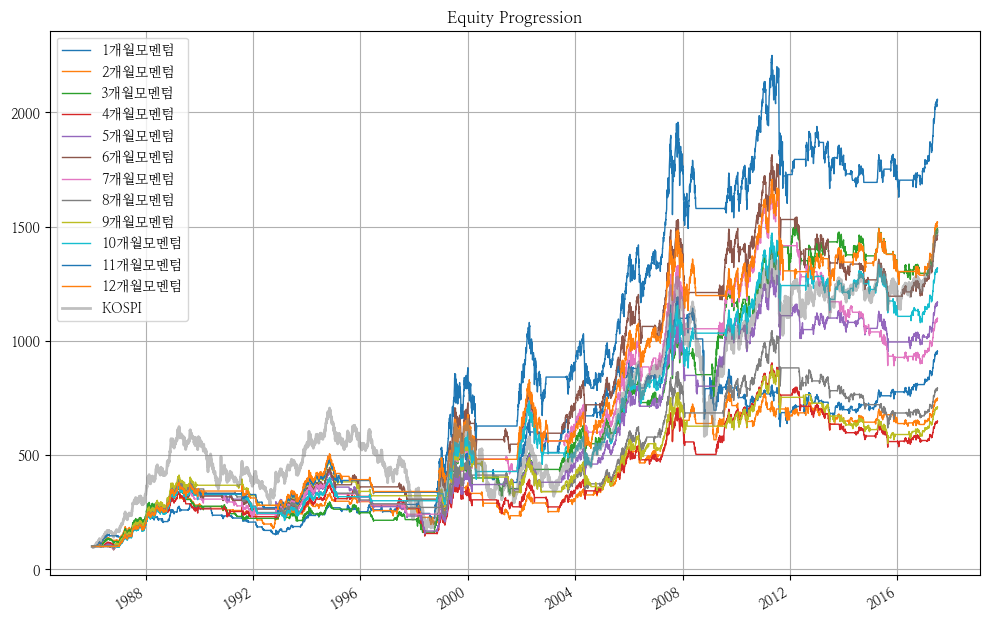

In [50]:
ax1 = r1_12.plot(figsize=(12, 8));
r_kospi.plot(ax=ax1, lw=2, ls='-', color='gray', alpha=0.5, figsize=(12, 8));

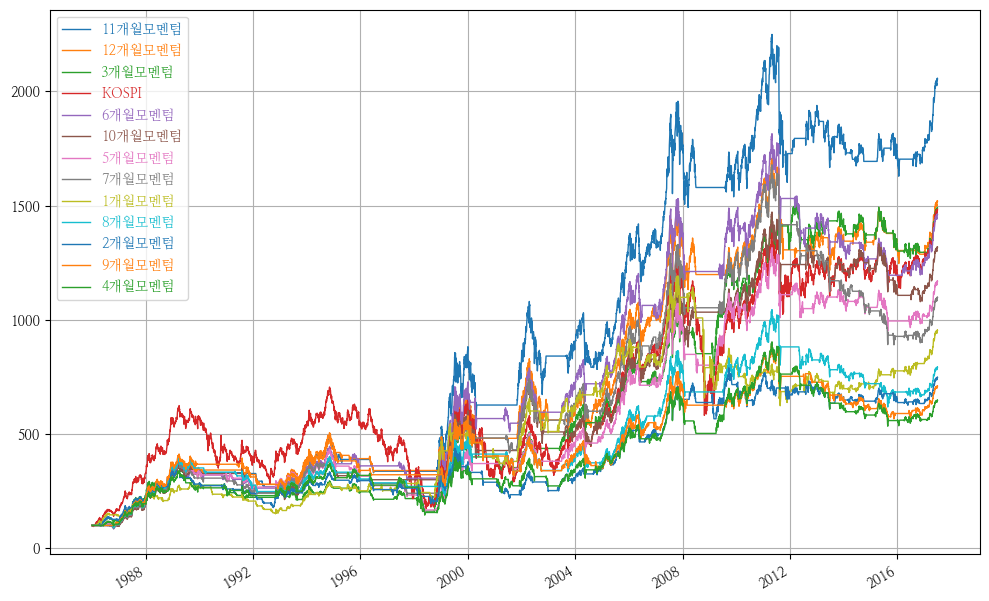

In [51]:
df = bt.merge(r1_12.prices, r_kospi.prices)
plot_df(df, logy=False)

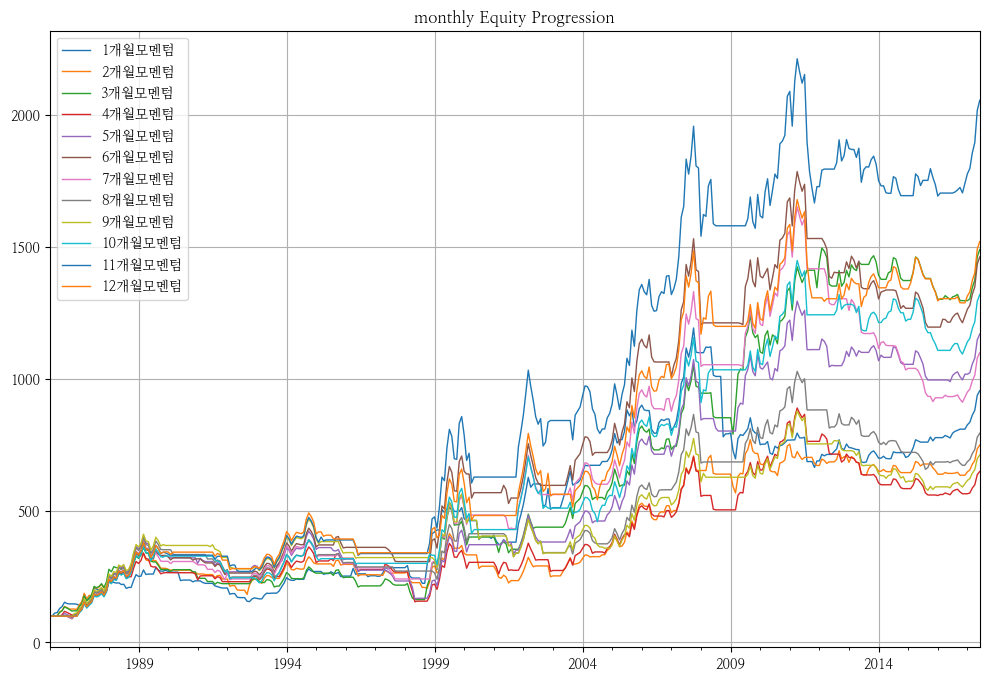

In [52]:
r1_12.plot(freq='M',figsize=(12,8));